# Capstone Project 2: Twitter Public Opinion Network Analysis for Bungie

This project's goal is to collect and analyze the available Twitter data for Bungie and their main game, Destiny 2.

The data are tweets about Bungie and Destiny 2 and the timelines (tweets made by) the Bungie and Destiny 2 official accounts.

This notebook is the data storytelling for the project. I'm going to visualize the numerical parts of the data, like retweet and favorite counts, as well as the follower counts of users in my dataset.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from datetime import datetime
import seaborn as sns
sns.set()

%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2019-03-20T14:26:19

CPython 2.7.15
IPython 5.8.0

compiler   : MSC v.1500 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [2]:
# These are the datetime columns
# Pandas can convert them all as-is
datetime_cols = ['created_at', 'quoted_status.created_at', 'retweeted_status.created_at']

In [3]:
destiny_2_tweet_min_df = pd.read_csv("../data/destiny_2_tweets_min.csv",
                                     encoding='utf-8', index_col=0, parse_dates=datetime_cols)
bungie_tweet_min_df = pd.read_csv("../data/bungie_tweets_min.csv",
                                  encoding='utf-8', index_col=0, parse_dates=datetime_cols)
bungie_timeline_min_df = pd.read_csv("../data/bungie_timeline_min.csv",
                                     encoding='utf-8', index_col=0, parse_dates=datetime_cols)
destiny_2_timeline_min_df = pd.read_csv("../data/destiny_2_timeline_min.csv",
                                        encoding='utf-8', index_col=0, parse_dates=datetime_cols)

### What should I visualize?

Let's see what columns look good. All dataframes have the same columns.

We should look at created_at, retweet_count, and favorite_count. We can then average the latter two over small periods of time, and then show the averages as functions of tweet creation time.

We can also look at the same parameters for retweeted and quoted tweets.

In [4]:
destiny_2_tweet_min_df.columns

Index([u'id', u'created_at', u'text', u'user.id', u'user.name',
       u'user.screen_name', u'user.followers_count', u'user.friends_count',
       u'user.statuses_count', u'user.verified', u'favorite_count',
       u'retweet_count', u'retweeted', u'in_reply_to_screen_name',
       u'in_reply_to_status_id', u'in_reply_to_user_id', u'is_quote_status',
       u'quoted_status.id', u'quoted_status.created_at', u'quoted_status.text',
       u'quoted_status.user.id', u'quoted_status.user.followers_count',
       u'quoted_status.user.friends_count',
       u'quoted_status.user.statuses_count', u'quoted_status.user.verified',
       u'quoted_status.favorite_count', u'quoted_status.retweet_count',
       u'quoted_status.retweeted', u'quoted_status.in_reply_to_screen_name',
       u'quoted_status.in_reply_to_status_id',
       u'quoted_status.in_reply_to_user_id', u'quoted_status_id',
       u'quoted_status.user.following', u'quoted_status.is_quote_status',
       u'retweeted_status.id', u'retwee

Name the dataframes so that I can distinguish them more easily if I plot data from all of them together.

In [5]:
destiny_2_tweet_min_df.name = 'Destiny 2 Tweets'
bungie_tweet_min_df.name = 'Bungie Tweets'
bungie_timeline_min_df.name = 'Bungie Timeline'
destiny_2_timeline_min_df.name = 'Destiny 2 Timeline'

#### Distribution of retweet counts

In [6]:
def plot_log_hist(df, col):
    _ = df.plot.hist(y=col, bins=25)
    _ = plt.yscale("log")
    
    # This helps to visualize single counts on the log scale
    _ = plt.ylim(ymin=0.1)
    
    _ = plt.ylabel('Log-Scaled Frequency')
    _ = plt.xlabel(col)
    _ = plt.legend()
    return _

In [7]:
bins = (destiny_2_tweet_min_df['retweet_count'].max() - destiny_2_tweet_min_df['retweet_count'].min()) / 1000
bins

134.97200000000001

In [8]:
def plot_all_df_hist(df_list, col, bins):
    """For each dataframe in the list
    Plot the given column on a histogram, overlaid together
    """
    # Find the largest number in the col of any dataframe
    # This will be the uppermost bin
    max_bin = 0
    for df in df_list:
        if df[col].max() > max_bin:
            max_bin = df[col].max()
    
    # Set up figure
    fig, ax = plt.subplots()
    bins = np.linspace(0, max_bin, num=bins)
    
    # Loop over dataframe list
    for df in df_list:
        # Make a histogram for the column on the same plot
        df.plot.hist(y=col, label=df.name, ax=ax, log=True, bins=bins, alpha=0.7)
        
    # Set lower y-limit to visualize single counts
    ax = plt.ylim(ymin=0.1)
    ax = plt.ylabel('Log-Scaled Frequency')
    return ax

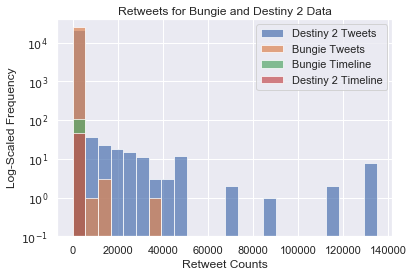

In [9]:
df_list = [destiny_2_tweet_min_df, bungie_tweet_min_df, bungie_timeline_min_df, destiny_2_timeline_min_df]
_ = plot_all_df_hist(df_list, 'retweet_count', 25)
_ = plt.xlabel('Retweet Counts')
_ = plt.title('Retweets for Bungie and Destiny 2 Data')

This plot shows that the tweets about Destiny 2 have overwhelmingly more retweets than the other 3 dataframes. The Bungie tweets number as many as Destiny 2 tweets, but are heavily concentrated into the first bin. It is a little hard to see, but the Bungie tweets and Destiny 2 tweets almost completely overlap in the first bin.

The timeline dataframes are significantly smaller, and also only present in the first bin, but number two orders of magnitude lower than the Bungie tweets.

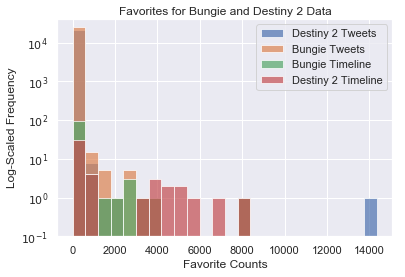

In [10]:
_ = plot_all_df_hist(df_list, 'favorite_count', 25)
_ = plt.xlabel('Favorite Counts')
_ = plt.title('Favorites for Bungie and Destiny 2 Data')

Favorites have a much smaller variance than retweets, and the timeline datasets have some decently high favorite counts. This makes sense, as the official Destiny 2 and Bungie accounts probably have as much, if not more, engagement as any tweet about them from someone else.

The first bin still has the majority of the data of each dataframe.

#### Correlate retweet and favorite counts

In [46]:
def plot_all_df_scatter(df_list, xcol, ycol):
    """For each dataframe in the list
    Plot (xcol, ycol) as a scatter plot 
    Overlaid together
    """
    
    # Colormap
    colors = cm.get_cmap('Accent')
    
    # Set up figure
    fig, ax = plt.subplots()
    #bins = np.linspace(0, max_bin, num=bins)
    
    # Loop over dataframe list
    for idx, df in enumerate(df_list):
        # Make a histogram for the column on the same plot
        df.plot.scatter(x=xcol, y=ycol, label=df.name, ax=ax, c=colors(idx))
        
    # Set lower y-limit to visualize single counts
    #ax = plt.ylim(ymin=0.1)
    #ax = plt.ylabel('Log-Scaled Frequency')
    ax = plt.legend()
    return ax

Okay. This is interesting, since it looks like tweets either have a lot of retweets or a lot of favorites, but not both. Let's log scale both axes and see if it looks any different.

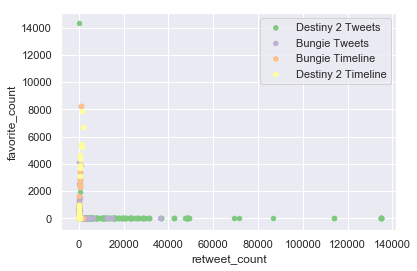

In [47]:
_ = plot_all_df_scatter(df_list, 'retweet_count', 'favorite_count')

This trend is more of what I expected, but I didn't expect to log-log-scale to get it.

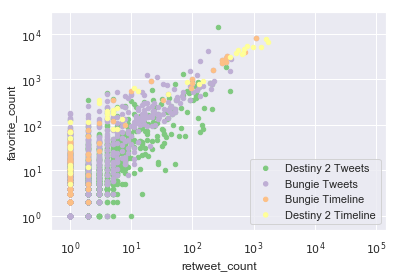

In [55]:
_ = plot_all_df_scatter(df_list, 'retweet_count', 'favorite_count')
_ = plt.yscale('log')
_ = plt.ylim([0.5, 30000])
_ = plt.xscale('log')
_ = plt.xlim([0.5, 145000])